In [259]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [232]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

# score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [133]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
#  model.add(Dense(15, activation='relu'))
#  model.add(BatchNormalization())
#  model.add(Dense(15, activation='relu'))
#  model.add(BatchNormalization())
 model.add(Dense(10, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 # Compile model
 model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])
 return model

In [260]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [226]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 10, 'epochs': 100}
CV score for GS -0.9898527780291049
Train AUC ROC Score for GS:  0.5872843571754411
Test AUC ROC Score for GS:  0.6124080249854428
Train Mean Absolute Error: 842    1.222290
783    0.083974
809    0.483256
613    0.462790
602    1.659374
         ...   
382    0.049755
327    0.306614
551    0.339444
127    0.096529
272    0.063206
Name: -LUMO(eV), Length: 780, dtype: float64 degrees.
Test Mean Absolute Error: 424    0.189005
176    0.825632
807    0.273389
371    0.983875
615    0.438550
         ...   
218    0.028125
563    0.703634
452    0.383381
810    0.351252
705    1.002417
Name: -LUMO(eV), Length: 196, dtype: float64 degrees.
Train R2:  -2.6629692004086256
Test R2:  -1.870776956531984
Train MSE:  0.32124975852993015
Test MSE:  0.2778520515641718


In [273]:
def create_new_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.3))
 model.add(Dense(20, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(10, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 model.add(BatchNormalization())
 # Compile model
 opt = optimizers.Adam(learning_rate=0.0016)
 model.compile(loss='MeanSquaredError', optimizer=opt, metrics=['accuracy'])
 return model

In [274]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_new_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees/.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 10, 'epochs': 100}
CV score for GS 0.06297895699597071
Train AUC ROC Score for GS:  0.748449126463357
Test AUC ROC Score for GS:  0.690858080567466
Train Mean Absolute Error: 470     0.071188
344     0.042939
734     0.056851
169     0.118818
940     0.040976
          ...   
1017    0.057779
601     0.319366
888     0.157965
132     0.045526
805     0.013214
Name: -LUMO(eV), Length: 499, dtype: float64 degrees.
Test Mean Absolute Error: 424    0.106863
176    0.142420
807    0.125675
371    0.007118
615    0.222684
         ...   
218    0.331151
563    0.053717
452    0.032340
810    0.513244
705    0.089708
Name: -LUMO(eV), Length: 196, dtype: float64 degrees/.
Train R2:  0.4683777430259295
Test R2:  0.1891793350612705
Train MSE:  0.0457444946944484
Test MSE:  0.07847638065062683


In [271]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val))

KerasRegressor(
	model=<function create_new_model at 0x2c1bcc3a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

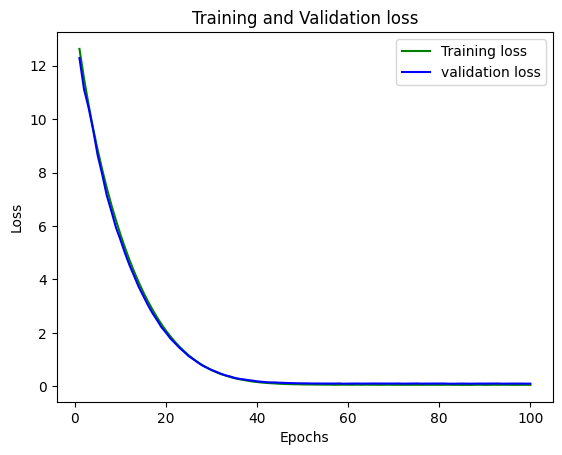

In [272]:
loss_train = model.history_['loss']
loss_val = model.history_['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [252]:
X_predict = model.predict(X_test)